In [31]:
library(bsts);
library(tidyverse);
library(rsample);
library(recipes);
library(tibble);
library(glue);
library(plyr);
library(timetk);
library(tidyquant);
library(tibbletime);
library(DMwR);


In [7]:
data <- read.csv('../../data/amelia_data.csv', sep='\t')

In [8]:
head(data)

timestamp,VAL_23.FT.92512.X.Value.average,VAL_23.FT.92521.X.Value.average,VAL_23.FT.92537.01.X.Value.average,VAL_23.FT.96151.X.Value.average,VAL_23.FT.96152.X.Value.average,VAL_23.FT.96158.X.Value.average,VAL_23.FT.96159.X.Value.average,VAL_23.KA.9101.M01.62B.X.Value.average,VAL_23.KA.9101_APE.VALUE.average,⋯,VAL_45.PDT.92506.X.Value.average,VAL_45.PDT.92606.X.Value.average,VAL_45.PT.92508.X.Value.average,VAL_45.PT.92608.X.Value.average,VAL_45.PT.92609.X.Value.average,VAL_45.TT.92506.X.Value.average,VAL_45.TT.92508.X.Value.average,VAL_45.TT.92606.X.Value.average,VAL_45.TT.92607A.X.Value.average,VAL_45.TT.92607B.X.Value.average
1.514765e+12,86513.12,4.401998,161173.2,17.38066,27.70608,18.39865,19.40636,9141.690,85.09909,⋯,0.5493244,0.4843041,2.275901,3.702201,3.726124,16.27771,46.15202,16.82067,108.5209,60.94572
1.514765e+12,95862.07,4.456219,164465.8,17.39795,27.79270,18.39151,19.42285,9252.934,83.62878,⋯,0.5509349,0.4832682,2.273809,3.685665,3.711056,16.27945,46.14248,16.76080,108.5977,60.81935
1.514765e+12,96191.59,4.505277,166973.2,17.40821,27.78446,18.38340,19.41854,9404.077,83.79804,⋯,0.5502207,0.4796795,2.273511,3.679600,3.704178,16.28329,46.09172,16.80574,108.7205,60.75282
1.514765e+12,91128.62,4.499127,164402.7,17.42042,27.78758,18.41191,19.42989,9264.223,83.78863,⋯,0.5509333,0.4816260,2.273505,3.666550,3.693027,16.28191,46.12929,16.86113,108.9298,60.78318
1.514765e+12,91532.35,4.507830,164649.2,17.39303,27.71386,18.39100,19.39947,9310.935,84.02951,⋯,0.5513894,0.4820547,2.276424,3.714492,3.740088,16.27711,46.24554,16.83897,109.0733,60.85556
1.514765e+12,88252.00,4.523839,164766.4,17.41381,27.74474,18.39843,19.41493,9275.117,83.54444,⋯,0.5508509,0.4865489,2.275578,3.707182,3.732400,16.29041,46.33954,16.85636,109.1350,60.95016


In [11]:
dataset <- data.frame(
    index = as_date(1:nrow(data)),
    flow=data['VAL_23.FT.92537.01.X.Value.average'], 
    p1=data['VAL_23.PDT.92530.X.Value.average'], 
    p2=data['VAL_23.PDT.92534.X.Value.average'], 
    p3=data['VAL_23.KA.9101.M01.62B.X.Value.average'],
    p4=data['VAL_23_PIC_92538_06.Z.X.Value.average']
)

colnames(dataset) <- c("index", "flow", 'p1', 'p2', 'p3', 'p4')
head(dataset)

index,flow,p1,p2,p3,p4
1970-01-02,161173.2,111.7744,105.1106,9141.690,9046.254
1970-01-03,164465.8,112.6428,105.8867,9252.934,9213.491
1970-01-04,166973.2,116.4864,109.6083,9404.077,9320.009
1970-01-05,164402.7,114.0231,107.2054,9264.223,9201.421
1970-01-06,164649.2,114.3888,107.4887,9310.935,9235.814
1970-01-07,164766.4,115.4733,108.4604,9275.117,9207.482


In [13]:
periods_train <- as.integer((nrow(dataset) * 0.8))
periods_test  <- 500
skip_span     <- 200

rolling_origin_resamples <- rolling_origin(
    data       = dataset,
    initial    = periods_train,
    assess     = periods_test,
    cumulative = FALSE,
    skip       = skip_span
)

attributes(rolling_origin_resamples)

$row.names
[1] 1 2 3 4 5 6

$class
[1] "rolling_origin" "rset"           "tbl_df"         "tbl"           
[5] "data.frame"    

$names
[1] "splits" "id"    

$initial
[1] 6771

$assess
[1] 500

$cumulative
[1] FALSE

$skip
[1] 200

In [14]:
# Plotting function for a single split
plot_split <- function(split, expand_y_axis = TRUE, alpha = 1, size = 1, base_size = 14) {
    
    # Manipulate data
    train_tbl <- training(split) %>%
        add_column(key = "training") 
    
    test_tbl  <- testing(split) %>%
        add_column(key = "testing") 
    
    data_manipulated <- bind_rows(train_tbl, test_tbl) %>%
        as_tbl_time(index = index) %>%
        mutate(key = fct_relevel(key, "training", "testing"))
        
    # Collect attributes
    train_time_summary <- train_tbl %>%
        tk_index() %>%
        tk_get_timeseries_summary()
    
    test_time_summary <- test_tbl %>%
        tk_index() %>%
        tk_get_timeseries_summary()
    
    # Visualize
    g <- data_manipulated %>%
        ggplot(aes(x = index, y = flow, color = key)) +
        geom_line(size = size, alpha = alpha) +
        theme_tq(base_size = base_size) +
        scale_color_tq() +
        labs(
            title    = glue("Split: {split$id}"),
            subtitle = glue("{train_time_summary$start} to {test_time_summary$end}"),
            y = "", x = ""
        ) +
        theme(legend.position = "none") 
    
    if (expand_y_axis) {
        
        sun_spots_time_summary <- dataset %>% 
            tk_index() %>% 
            tk_get_timeseries_summary()
        
        g <- g +
            scale_x_date(limits = c(sun_spots_time_summary$start, 
                                    sun_spots_time_summary$end))
    }
    
    return(g)
}

In [15]:
# Plotting function that scales to all splits 
plot_sampling_plan <- function(sampling_tbl, expand_y_axis = TRUE, 
                               ncol = 3, alpha = 1, size = 1, base_size = 14, 
                               title = "Sampling Plan") {
    
    # Map plot_split() to sampling_tbl
    sampling_tbl_with_plots <- sampling_tbl %>%
        mutate(gg_plots = map(splits, plot_split, 
                              expand_y_axis = expand_y_axis,
                              alpha = alpha, base_size = base_size))
    
    # Make plots with cowplot
    plot_list <- sampling_tbl_with_plots$gg_plots 
    
    p_temp <- plot_list[[1]] + theme(legend.position = "bottom")
    legend <- get_legend(p_temp)
    
    p_body  <- plot_grid(plotlist = plot_list, ncol = ncol)
    
    p_title <- ggdraw() + 
        draw_label(title, size = 18, fontface = "bold", colour = palette_light()[[1]])
    
    g <- plot_grid(p_title, p_body, legend, ncol = 1, rel_heights = c(0.05, 1, 0.05))
    
    return(g)
    
}

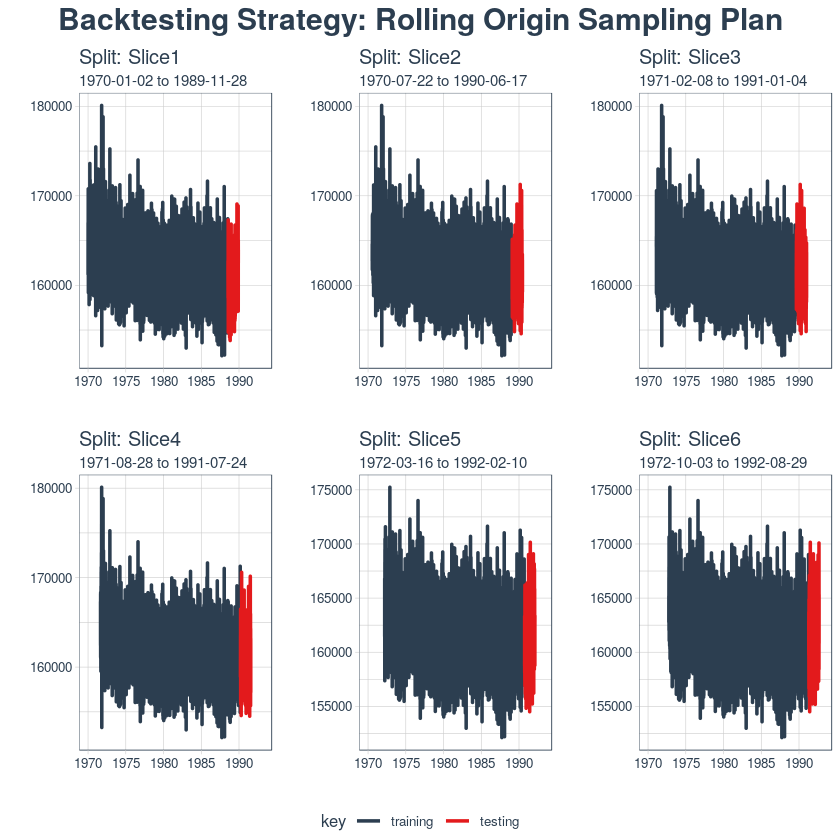

In [16]:
rolling_origin_resamples %>%
    plot_sampling_plan(expand_y_axis = T, ncol = 3, alpha = 1, size = 1, base_size = 10, 
                       title = "Backtesting Strategy: Rolling Origin Sampling Plan")

In [22]:
predict_bsts <- function(split, ephocs, univariate = F, lag_setting = 0, niter = 100, response = "p1", ...) {
    trn <- training(split)
    tst <- testing(split)
    
    df_tst_rec <- recipe(index ~., tst) %>%
        step_sqrt(all_predictors()) %>%
        step_center(all_predictors()) %>%
        step_scale(all_predictors()) %>%
        prep()
    
    df_trn_rec <- recipe(index ~., trn) %>%
        step_sqrt(all_predictors()) %>%
        step_center(all_predictors()) %>%
        step_scale(all_predictors()) %>%
        prep()
    
    df_trn <- bake(df_trn_rec, trn)
    df_tst <- bake(df_tst_rec, tst)
    
    center_history_trn <- df_trn_rec$steps[[2]]$means
    scale_history_trn  <- df_trn_rec$steps[[3]]$sds
    
    center_history_tst <- df_tst_rec$steps[[2]]$means
    scale_history_tst  <- df_tst_rec$steps[[3]]$sds
     
    df <- bind_rows(
        df_trn %>% add_column(key = "training"),
        df_tst %>% add_column(key = "testing")
    ) %>% 
        as_tbl_time(index = index)
    
    names(df)[names(df) == response] <- 'response'
                    
    lag_train_tbl <- df %>%
        mutate(response = lead(response, n = lag_setting)) %>%
        filter(!is.na(response)) %>%
        filter(key == "training") %>%
        select(-index, -key)
    
    lag_test_tbl <- df %>%
        mutate(response = lead(response, n = lag_setting)) %>%
        filter(!is.na(response)) %>%
        filter(key == "testing") %>%
        select(-index, -key)
    
    x_test <- lag_test_tbl %>% select(-response)
    y_test <- lag_test_tbl$response

    ss <- AddSemilocalLinearTrend(list(), lag_train_tbl$response)
    model <- bsts(
        response ~., 
        state.specification = ss, 
        niter = niter,
        ping = 0,
        data = lag_train_tbl
    )

    pred <- predict(model, newdata = x_test)   

    tbl_1 <- lag_test_tbl %>%
        add_column(key = "actual") %>%
        add_column(unscaled = (lag_test_tbl$response * scale_history_tst[[response]] + center_history_tst[[response]])^2) %>%
        select(response, key, unscaled)
        
    tbl_2 <- lag_train_tbl %>%
        add_column(key = "train") %>%
        add_column(unscaled = (lag_train_tbl$response * scale_history_trn[[response]] + center_history_trn[[response]])^2) %>%
        select(response, key, unscaled)
    
    tbl_3 <- data.frame(
        response = pred$mean,
        unscaled = (pred$mean * scale_history_tst[[response]] + center_history_tst[[response]])^2,
        key = "predict"
    )
 
    return(list(
        pred = rbind.fill(tbl_2, tbl_1, tbl_3),
        y_test = y_test,
        model = pred
    ))
}

In [23]:
models <- rolling_origin_resamples %>% 
    mutate(predict = map(splits, predict_bsts, univariate = F, niter = 1000, lag_setting = 0, response = "flow"))

In [24]:
calc_rmse <- function(prediction_tbl) {
    estimated <- prediction_tbl$pred %>%
        filter(key == "predict") %>%
        pull(response)
    
    truth <- prediction_tbl$pred %>%
        filter(key == "actual") %>%
        pull(response)
    
    return (mean(abs(estimated - truth)))
}

In [25]:
models <- models %>%
    mutate(mae = data.frame(
        mae = map_dbl(predict, calc_rmse),
        id = id
    )
)
models$mae
cat(glue("Mean MAE: {round(mean(models$mae[,1]), 2)}"))

mae,id
0.3132321,Slice1
0.3233756,Slice2
0.3651406,Slice3
0.2183265,Slice4
0.1892081,Slice5
0.1787772,Slice6


Mean MAE: 0.26

In [27]:
write.table(models$predict[[1]]$pred, "../../data/bsts_prediction.csv",
            na = "",
            row.names = FALSE,
            sep = "\t")